# ЗАДАЧА

К вам обратился представитель крупного агентства недвижимости со следующей проблемой:

Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивает до уровня конкурентов. А это сказывается на наших финансовых показателях. Твоя задача — разработать модель, которая бы позволила обойти конкурентов по скорости и качеству совершения сделок. Датасет прикладываю.

## НУЖНО
разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.  

In [1]:
#импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
from statistics import mean
import pickle

In [2]:
#настройки
%matplotlib inline
pd.options.display.max_columns = 30

In [3]:
#загружаем данные и делаем копию датасета, чтобы работать с копией
data_source = pd.read_csv('data.csv')

In [4]:
data = data_source.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [6]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


## 1. target

In [7]:
#количество строк, в которых не задана стоимость дома
sum(data['target'].isnull())

2481

In [8]:
#Посмотрим на статусы этих домов (foreclosure = потеря права выкупа, pending = незавершенное строительство)
data['status'][data['target'].isnull()].unique()

array([nan, 'Pre-foreclosure / auction', ' / auction', 'foreclosure',
       'Pre-foreclosure', 'Foreclosed', 'for sale', 'recently sold',
       'New construction', 'Pending', 'Auction', 'Closed', 'Active',
       'Sold: $285,000', 'Sold: $15,000'], dtype=object)

In [9]:
#отложим строки, в которых не задана целевая переменная, в сторону. 
#В дальнейшем эти данные можно будет использовать для примера работы прототипа
data_for_example = data[data['target'].isnull()]
data = data[data['target'].notnull()]

print('Осталось {0} записей из {1}'.format(len(data), len(data_source)))

Осталось 374704 записей из 377185


In [10]:
#Смотрим, какие значения есть в target. Нам нужно, чтобы они были все числовые
data['target'].unique()

array(['$418,000', '$310,000', '$2,895,000', ..., '$815,881', '342,969',
       '$171,306'], dtype=object)

In [11]:
#убираем все символы, кроме цифр. Приводим к формату int
regex = re.compile('\D+')
data['target'] = data['target'].apply(lambda x: int(regex.sub('', str(x))))

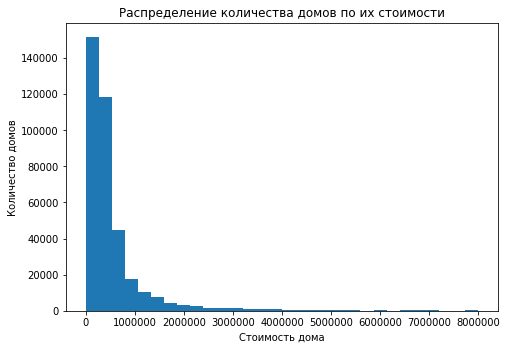

In [12]:
fig_target = plt.figure()
axes_target = fig_target.add_axes([0, 0, 1, 1])
axes_target.hist(data['target'], range = (data['target'].min(), 8000000), bins = 30)
axes_target.set_xlabel('Стоимость дома')
axes_target.set_ylabel('Количество домов')
axes_target.set_title('Распределение количества домов по их стоимости')
plt.show()
#видим, что целевая переменная сосредоточена до 1 млн, и распределение мало напоминает нормальное 
# + есть выбросы значений больше 8 млн (поставлено такое ограничение, так как если брать во внимание все значения из датасета,
# то получается малоинформативный график)

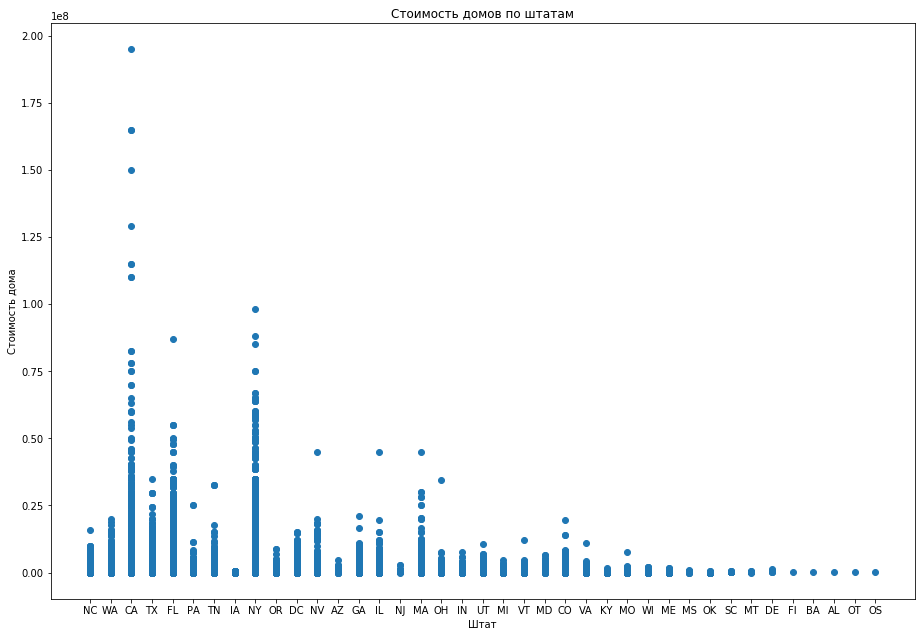

In [13]:
X = data[['state', 'target']]

fig_target_st = plt.figure()
axes_target_st = fig_target_st.add_axes([0, 0, 2, 2])
axes_target_st.set_xlabel('Штат')
axes_target_st.set_ylabel('Стоимость дома')
axes_target_st.set_title('Стоимость домов по штатам')
plt.plot(X['state'], X['target'],'o')
plt.show()

In [14]:
data['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Отметим, что стоимость домов сильно отличается по штатам. Добавим еще одну колонку со средней стоимостью дома по штату.

In [15]:
mean_target = data.groupby(by = ['state'])['target'].mean()

In [18]:
data['state_mean'] = data['state'].apply(lambda x: mean_target[x])

## 2. поле status

In [19]:
data['status'].unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', ' / auction',
       'Under Contract', 'Pre-foreclosure / auction',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'Active Under Contract', 'foreclosure',
       'Foreclosed', 'Option Pending', 'Under Contract Show', 'for rent',
       'Auction', 'A Active', 'Contingent', 'Pending   Continue To Show',
       'Price Change', 'Back on Market', 'Active Option', 'Foreclosure',
       'Coming soon: Nov 21.', 'Contingent Finance And Inspection',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Active', 'Contingent 

In [20]:
#разделяем данные на 2 категории. Для продажи и для аренды. Так как от этого фактора сильно зависит итоговая стоимость
data['rent_sale']=data['status'].apply(lambda x: 1 if str(x).lower().find('rent') >-1 else 0)

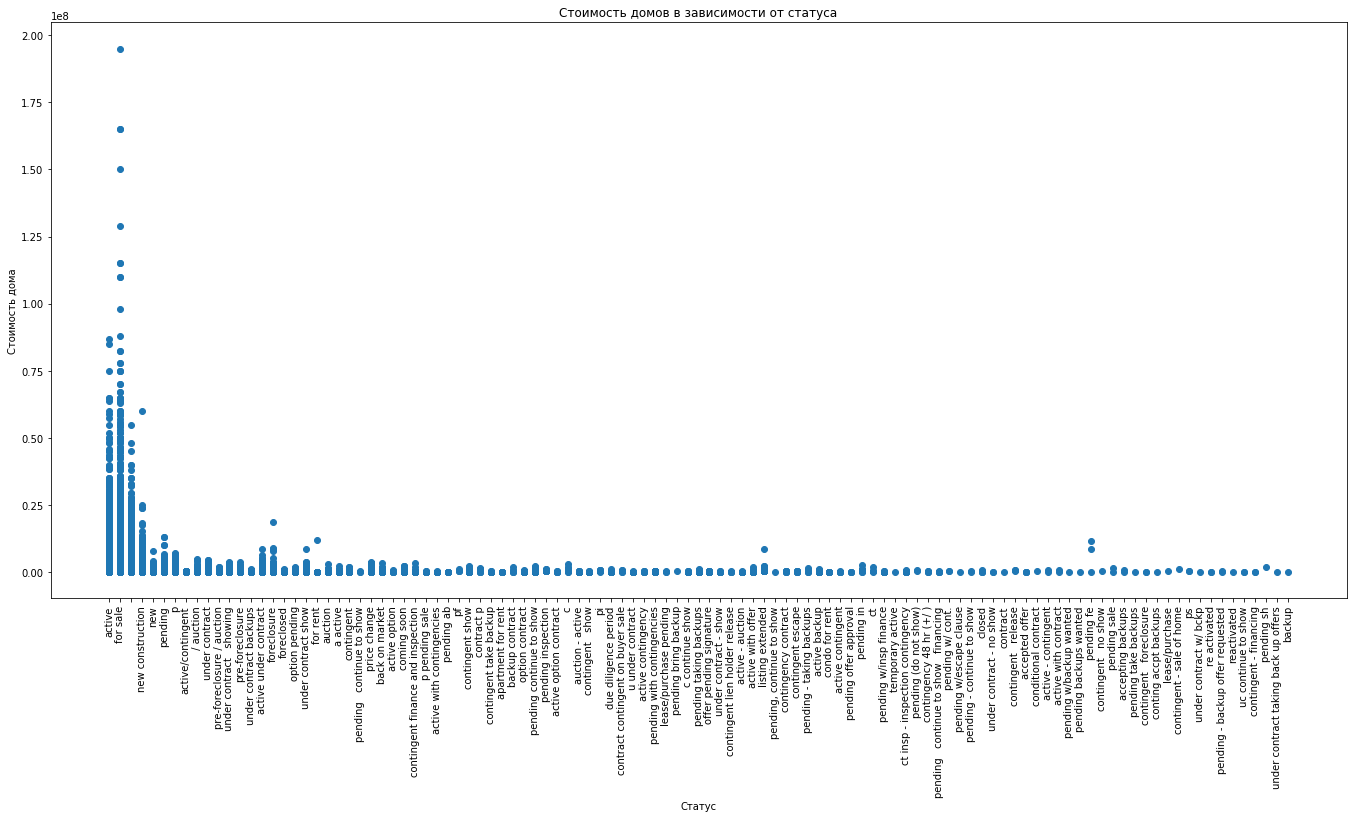

In [21]:
data['status'].fillna('', inplace = True)
data['status'] = data['status'].apply(lambda x: 'coming soon' if str(x).lower().find('coming soon') >-1 else x.lower())
X_status = data[['status', 'target']]

fig_target_status = plt.figure()
axes_target_status = fig_target_status.add_axes([0, 0, 3, 2])
axes_target_status.set_xlabel('Статус')
axes_target_status.set_ylabel('Стоимость дома')
axes_target_status.set_title('Стоимость домов в зависимости от статуса')
plt.xticks(rotation=90)
#axes_target_status.set_xticklabels(X_status['status'], rotation =90 )
plt.plot(X_status['status'], X_status['target'],'o')
plt.show()

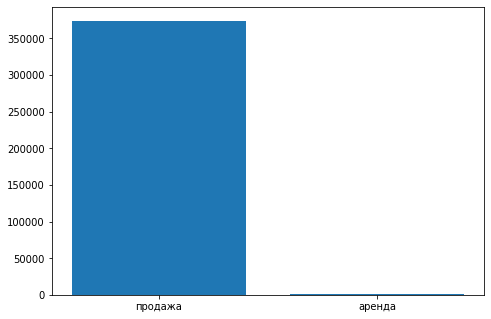

In [22]:
#посмотрим после обработки
rent_sale = data.groupby('rent_sale')['rent_sale'].count().sort_values(ascending=False)

fig_rent = plt.figure()
axes_rent = fig_rent.add_axes([0,0,1,1])
axes_rent.bar(x = ['нет', 'да'], height = rent_sale.values)
axes_rent.set_xticklabels(['продажа', 'аренда'], rotation = 0 )    #  Поворот текста
plt.show()

## 3. поле propertyType

In [23]:
def replace_property(row):
    
    if row in ['single-family home','Single Family Home','Single Family']:
        return 'single family home'
    elif row == 'Condo':
        return 'condo'
    elif row in ['Townhouse', 'Townhome']:
        return 'townhouse'
    elif row in ['Multi-Family Home','multi-family','Multi Family','Multi-Family']:
        return 'multi family home'
    elif row in ['1 Story','One Story']:
        return '1 story'
    elif row in ['2 Stories', '2 Story', 'Two Story']:
        return '2 stories'
    elif row in ['mobile/manufactured', 'Mfd/Mobile Home', 'Mobile / Manufactured']:
        return 'mobile/manufactured'
    elif row in ['Cooperative', 'coop']:
        return 'cooperative'
    elif row in ['Apartment', 'apartment']:
        return 'apartment'
    elif row in ['lot/land', 'Land']:
        return 'land'
    elif row in ['Other Style', 'Other']:
        return 'other style'
    else:
        return row

In [24]:
#приводим к более-менее одинаковым названиям
data['prop_type']=data['propertyType'].apply(lambda x: replace_property(x))

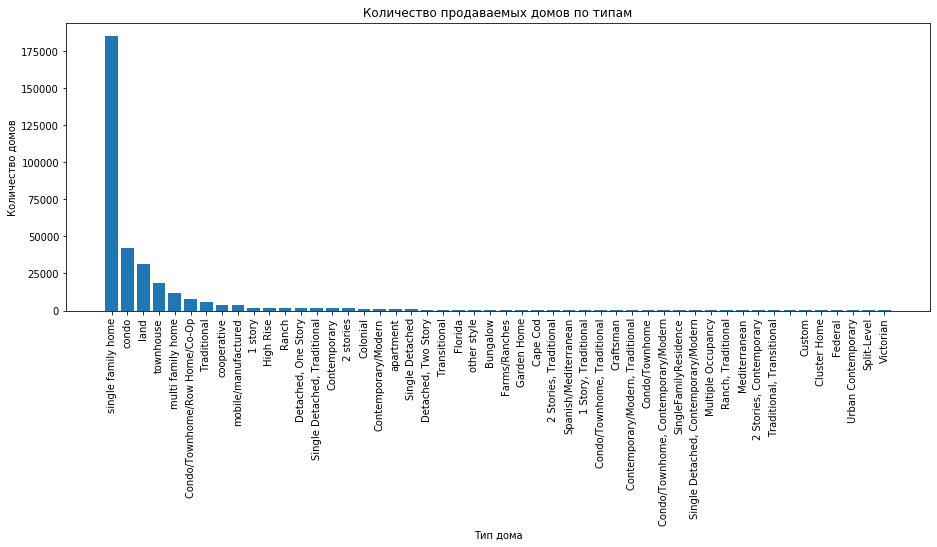

In [25]:
#считаем распределение по типам собственности
#prop_type = data.groupby('propertyType')['propertyType'].count().sort_values(ascending=False)
prop_type = data.groupby('prop_type')['prop_type'].count().sort_values(ascending=False)

NUM_PROP =50 #выводим первые 30 по численности
fig_prop = plt.figure()
axes_prop = fig_prop.add_axes([0,0,2,1])
axes_prop.bar(x = prop_type.index[:NUM_PROP], height = prop_type.values[:NUM_PROP])
axes_prop.set_ylabel('Количество домов')
axes_prop.set_xlabel('Тип дома')
axes_prop.set_title('Количество продаваемых домов по типам')

axes_prop.set_xticklabels(prop_type.index, rotation =90 )    #  Поворот текста
plt.show()

In [26]:
#считаем hash
hash_space=50
data['prop_type']=data['prop_type'].apply(lambda x: hash(''.join(str(x).lower().split())) % hash_space)
#удаляем исходное поле
data = data.drop(['propertyType'], axis = 'columns')

## 4. поля city, street
объединяем и считаем hash

In [27]:
data[['city', 'street']]

,city,street
0,Southern Pines,240 Heather Ln
1,Spokane Valley,12911 E Heroy Ave
2,Los Angeles,2005 Westridge Rd
3,Dallas,4311 Livingston Ave
4,Palm Bay,1524 Kiscoe St
...,...,...
377180,Miami,20800 NE 23rd Ave
377181,Chicago,3530 N Lake Shore Dr #4B
377182,Jamaica,15509 Linden Blvd
377183,Houston,7810 Pereida St


In [28]:
# заполняем пропущенные значения на "no_city"
data['city'].fillna('no_city', inplace=True)

# приводим все буквы к нижнему регистру, так как есть вероятность, что города могут быть написаны по-разному
data['city_lower'] = data['city'].apply(lambda x: str(x).lower() if x != ' ' else 'no_city')
print(data['city'].nunique(), '->', data['city_lower'].nunique())

2020 -> 1904


In [29]:
hash_space = 2020
data['city_hash']=data['city'].apply(lambda x: hash(''.join(x.lower().split())) % hash_space)
data['street_hash']=data['street'].apply(lambda x: hash(''.join(str(x).lower().split())) % hash_space)
data['address_hash']=data[['city', 'street']].apply(lambda x: hash(''.join(str(x[0]).lower().split()) + 
                                                                  ''.join(str(x[1]).lower().split())) % hash_space, axis=1)

In [30]:
data[['city_hash', 'city', 'street', 'street_hash', 'address_hash']]

,city_hash,city,street,street_hash,address_hash
0,1210,Southern Pines,240 Heather Ln,1589,1599
1,1739,Spokane Valley,12911 E Heroy Ave,1990,531
2,1513,Los Angeles,2005 Westridge Rd,679,412
3,1693,Dallas,4311 Livingston Ave,1457,1764
4,1987,Palm Bay,1524 Kiscoe St,780,828
...,...,...,...,...,...
377180,505,Miami,20800 NE 23rd Ave,1878,615
377181,1885,Chicago,3530 N Lake Shore Dr #4B,813,637
377182,887,Jamaica,15509 Linden Blvd,564,651
377183,145,Houston,7810 Pereida St,570,15


### поле city отдельно

In [31]:
data_source['city'].nunique()

2026

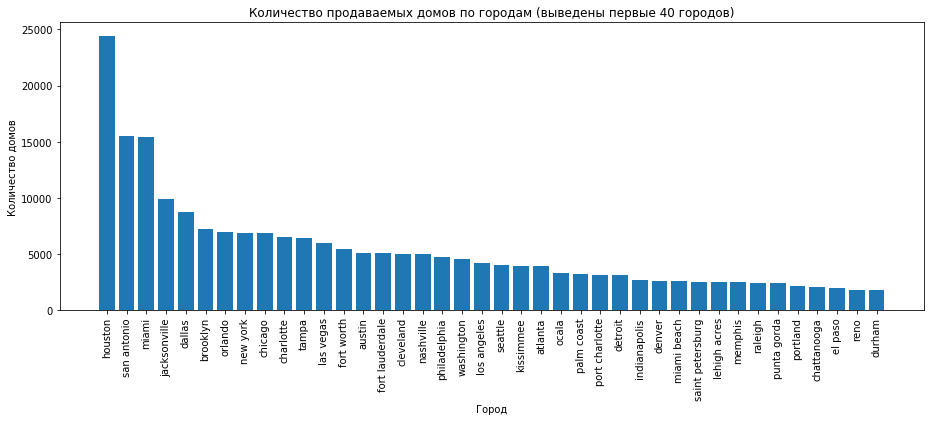

In [32]:
#считаем распределение по городам
cities = data.groupby('city_lower')['city_lower'].count().sort_values(ascending=False)

#групбай удаляет значения, где город не указан. Добавим это количество в 
NUM_SITIES = 40

fig_cities = plt.figure()
axes_cities = fig_cities.add_axes([0,0,2,1])
axes_cities.bar(x = cities.head(NUM_SITIES).index, height = cities.head(NUM_SITIES).values)
axes_cities.set_xlabel('Город')
axes_cities.set_ylabel('Количество домов')
axes_cities.set_title('Количество продаваемых домов по городам (выведены первые '+str(NUM_SITIES)+' городов)')

axes_cities.set_xticklabels(cities.head(NUM_SITIES).index, rotation =90 )    #  Поворот текста
plt.show()

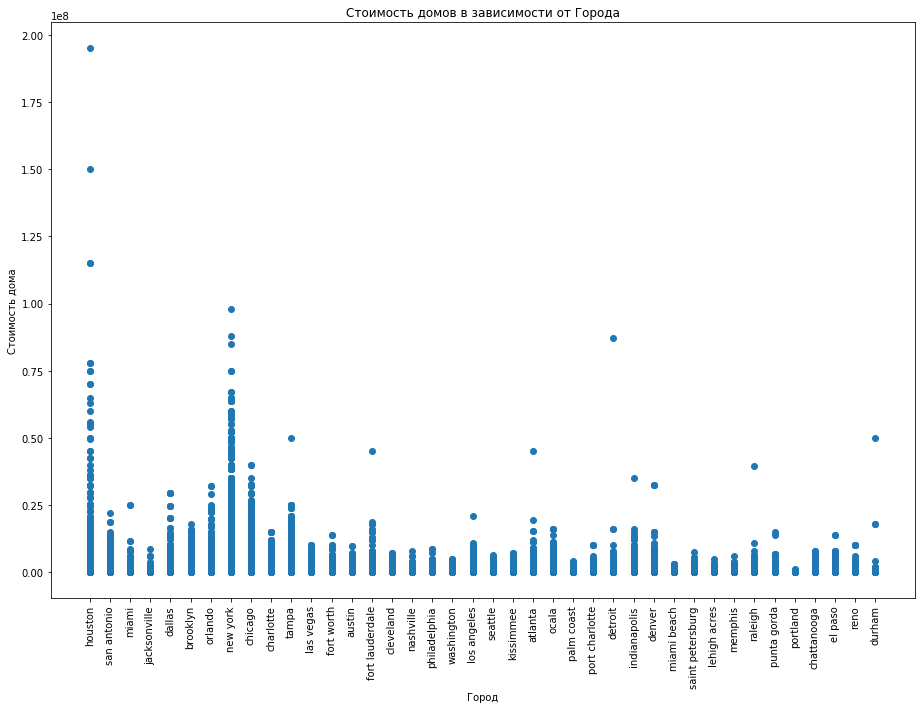

In [33]:
X_city = data[data['city_lower'].isin(cities.head(NUM_SITIES).index)][['city_lower', 'target']]

fig_target_city = plt.figure()
axes_target_city = fig_target_city.add_axes([0, 0, 2, 2])
axes_target_city.set_xlabel('Город' )
axes_target_city.set_ylabel('Стоимость дома')
axes_target_city.set_title('Стоимость домов в зависимости от Города')
axes_target_city.set_xticklabels(cities.head(NUM_SITIES).index, rotation =90 )
plt.plot(X_city['city_lower'], X_city['target'],'o')
plt.show()

In [34]:
#удаляем исходные и ненужные столбцы
data = data.drop(['city', 'street','city_lower'], axis = 'columns')

## 5. поле baths

In [35]:
#смотрим на значения, которые есть в поле beds в зависимости от типа идентификатора
data[data['mls-id'].notnull()]['baths'].unique()[:50]

array(['Bathrooms: 2', '2 ba', 'Bathrooms: 5', 'Bathrooms: 1',
       'Bathrooms: 3', '3 ba', 'Bathrooms: 4', '1 ba', 'Bathrooms: 6',
       '6 ba', nan, 'Bathrooms: 19', '4 ba', '12 ba', 'Bathrooms: 10',
       '5 ba', '-- baths', 'Bathrooms: 7', 'Bathrooms: 8', 'Bathrooms: 9',
       'Bathrooms: 13', '7 ba', 'Bathrooms: 12', '2.5 ba', '8 ba',
       '4.5 ba', '9 ba', 'Bathrooms: 11', 'Bathrooms: 27', '2 baths',
       'Bathrooms: 18', 'Bathrooms: SemiMod', '2.25 ba', 'Bathrooms: 24',
       'Bathrooms: 14', '10 ba', 'Bathrooms: 16', 'Bathrooms: 21',
       '13 ba', '5.5 ba', '16 ba', '11 ba', '3.5 ba', '1.5 ba',
       'Bathrooms: 15'], dtype=object)

In [36]:
data[data['MlsId'].notnull()]['baths'].unique()[:50]

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3', '1,750',
       '4 Baths', '1,000', '7 Baths', '2.0', '3.0', '4.0', '2.1 Baths',
       '1', '4.5', '6 Baths', '5', '2,500', '1.0', '5 Baths', '1.5', '4',
       '~', '2.5', '4,000', '2,000', '3,000', '8.0', '0', '5.0', '1,500',
       '7.0', '1,250', '9 Baths', '2,250', '2.5 Baths', '6.0', '12 Baths',
       '5.5', '3.5 Baths', '3,500', '2,750', '750', '5.5+', '6',
       '10 Baths', '10.0', '2.5+'], dtype=object)

In [37]:
def make_baths_count(row):
    row = str(row)
    row = row.replace('Bathrooms: ', '').replace(' Baths', '').replace(' ba', '').replace(',','.')
    try:
        if row != 'nan':
            return float(row)
        else:
            return 0
    except:
        return 0

In [38]:
data['baths_count']=data['baths'].apply(lambda x: make_baths_count(x))

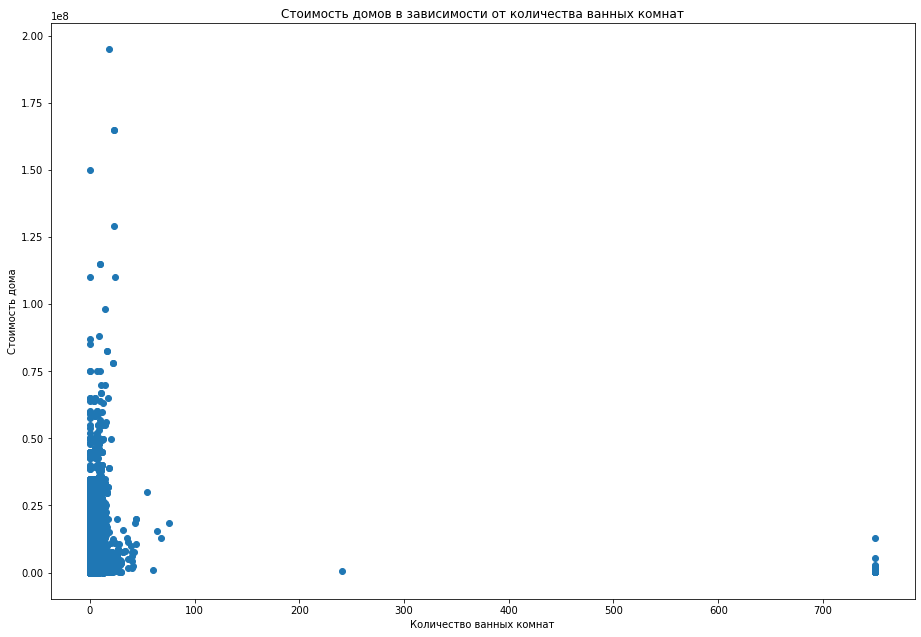

In [39]:
X_bath = data[['baths_count', 'target']]

fig_target_bath = plt.figure()
axes_target_bath = fig_target_bath.add_axes([0, 0, 2, 2])
axes_target_bath.set_xlabel('Количество ванных комнат')
axes_target_bath.set_ylabel('Стоимость дома')
axes_target_bath.set_title('Стоимость домов в зависимости от количества ванных комнат')
plt.plot(X_bath['baths_count'], X_bath['target'],'o')
plt.show()

In [40]:
# удаляем выбросы. Количество ванных комнат больше 200
data = data.loc[data['baths_count']<200]

In [41]:
data = data.drop(['baths'], axis = 'columns')

## 6. поле beds

In [42]:
#смотрим на значения, которые есть в поле beds в зависимости от типа идентификатора
data[data['mls-id'].notnull()]['beds'].unique()[:50]

array(['3 bd', '4 bd', '5 bd', '2 bd', '1 bd', '6 bd', '16 bd', '13 bd',
       '-- bd', '6,351 sqft', '7 bd', '9 bd', '5,662 sqft', '12 bd',
       '8 bd', '24 bd', '0.71 acres', '10 bd', '0.3 acres', '1.8 acres',
       '0.32 acres', '11 bd', '19 bd', '20 bd', '0.63 acres', '14 bd',
       '27 bd', '15 bd', '1,960 sqft', '26 bd', '0.31 acres',
       '3,920 sqft', '7,840 sqft', '2,250 sqft', '4,199 sqft', '23 bd',
       '10 acres', '0.86 acres', '8,276 sqft', '0.29 acres', '2,178 sqft',
       '2,000 sqft', '0.57 acres', '0.85 acres', '0.43 acres', '17 bd',
       '0.41 acres', '1 acre', '4.64 acres', '5,227 sqft'], dtype=object)

In [43]:
data[data['MlsId'].notnull()]['beds'].unique()[:50]

array(['4', '3 Beds', '5 Beds', nan, '2 Beds', '3', '4 Beds', 'Baths',
       '8 Beds', '2', '2.0', '5', '1', '3.0', '6 Beds', 'Bath', '12 Beds',
       '6', '14', '0.25 acres', '7', '5.0', '4.0', ' ', '7 Beds',
       '9 Beds', '0.44 acres', '0', '1.43 acres', '0.32 acres',
       '8,637 sqft', '7.0', '16 Beds', '9.7 acres', '1.0', '8',
       '10,310 sqft', '6,250 sqft', '2 acres', '5,000 sqft', '0.96 acres',
       '6.0', '6.31 acres', '0.6 acres', '5,662 sqft', '2,200 sqft', '10',
       '10 Beds', '0.46 acres', '0.59 acres'], dtype=object)

In [44]:
def make_beds_count(row):
    row = str(row)
    if row.find(' Beds') > -1:
        try:
            return int(row.replace(' Beds', ''))
        except: #если указано что-то другое #1-2
            return 1
    elif row.find(' bd') >-1:
        try:
            return int(row.replace(' bd', ''))
        except: #если указано что-то другое #--
            return 0
    else: 
        try:
            return int(row)
        except:
            return 0

def make_beds_square(row): #переводим в квадратные метры
    row = str(row)
    if row.find(' sqft') > -1:
        try:
            return float(row.replace(' sqft', '').replace(',',''))*0.093
        except: 
            return 0
    elif row.find(' acres') > -1:
        try:
            return float(row.replace(' acres', '').replace(',',''))*4046.86
        except: 
            return 0
    else:
        return 0
        

In [45]:
data['beds_count']=data['beds'].apply(lambda x: make_beds_count(x))
data['beds_square']=data['beds'].apply(lambda x: make_beds_square(x))
#удаляем лишний столбец
data = data.drop(['beds'], axis = 'columns')

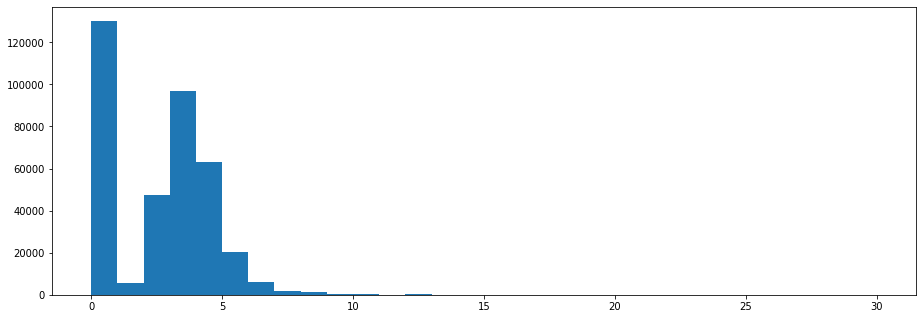

In [46]:
fig_beds = plt.figure()
axes_beds = fig_beds.add_axes([0, 0, 2, 1])
axes_beds.hist(data['beds_count'], range = (0, 30), bins=30)
plt.show()

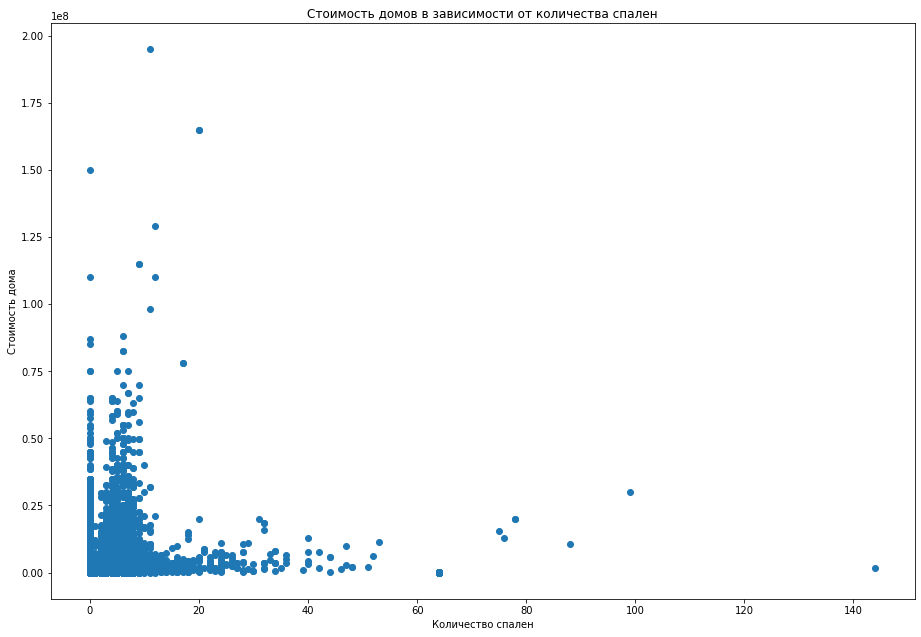

In [47]:
X1 = data[['beds_count', 'target']]

fig_target_beds = plt.figure()
axes_target_beds = fig_target_beds.add_axes([0, 0, 2, 2])
axes_target_beds.set_xlabel('Количество спален')
axes_target_beds.set_ylabel('Стоимость дома')
axes_target_beds.set_title('Стоимость домов в зависимости от количества спален')
plt.plot(X1['beds_count'], X1['target'],'o')
plt.show()

In [48]:
data[data['beds_count']>90]

,status,private pool,homeFacts,fireplace,schools,sqft,zipcode,state,stories,mls-id,PrivatePool,MlsId,target,state_mean,rent_sale,prop_type,city_hash,street_hash,address_hash,baths_count,beds_count,beds_square
7324,active,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': ['7', '8', '4', '8', '9', '6', 'NR...",62376,78045,TX,NaN,NaN,NaN,20193851,1590000,4.617258e+05,0,33,399,493,706,2.0,144,0.0
110423,for sale,NaN,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,"[{'rating': ['2/10', '3/10'], 'data': {'Distan...","30,500",02215,MA,NaN,NaN,NaN,"81, Boston, MA 02215",30000000,1.454522e+06,0,33,1534,1327,1947,55.0,99,0.0


## 7. поле schools

In [49]:
#пример данных
data['schools'][0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [50]:
def make_schools(row):

    #разбираем, какие классы есть в близлежащих школах
    grades = eval(row[1:-1])['data']['Grades']
    
    result={'K':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0, 'PK':0}
    for i in grades:
        i = (str(i).replace(' to ', '-').replace('–', '-')).split(',')
        for ii in i:
            ii = ii.strip().upper().replace('PK','PRESCHOOL')
            if 'PRESCHOOL' in ii:
                result['PK']+=1
                ii = ii.replace('PRESCHOOL','1')
            if 'K' in ii:
                result['K']+=1
                ii = ii.replace('K','1')
            if '-' in ii:
                j = ii.split('-')
                for k in range(int(j[0]), int(j[1])+1):
                    result[str(k)]+=1
    
    #считаем количество школ 
    result['schools_count']=len(eval(row[1:-1])['rating'])
    
    #считаем дистанцию по школам
    result['min_dist']=0
    result['max_dist']=0
    result['mean_dist']=0

    data_list = eval(row[1:-1])['data']['Distance']
    dist_list=[]
    for i in data_list:
        i = i.replace('mi', '').strip()
        try:
            i = float(i)
            dist_list.append(i)
        except:
            print(i)
            i = 0 
    if len(dist_list)>0:
        result['min_dist']=min(dist_list)
        result['max_dist']=max(dist_list)
        result['mean_dist']=mean(dist_list)
    
    #разбираем рейтинги школ
    regex = re.compile('\D+')
    data2_list = eval(row[1:-1])['rating']
    rate_list=[]
    if len(data2_list)>0:
        for i in data2_list:
            i = i.replace('/10','')
            i = regex.sub('', str(i))
            if i != '':
                rate_list.append(int(i))
            else:
                rate_list.append(0)
    if len(rate_list)>0:
        result['max_rate'] = max(rate_list) 
    else:
        result['max_rate']=0
        
    if len(dist_list)==len(rate_list):
        result['average_rate_school']=np.array(dist_list)@np.array(rate_list)
    else:
        result['average_rate_school']=0
    
    return pd.Series(result)

In [51]:
#добавляем кучу новых столбцов с характеристиками по школам
new_columns = ['K','1','2','3','4','5','6','7','8','9','10','11','12', 'PK', 'schools_count', 
              'min_dist', 'max_dist', 'mean_dist', 'max_rate', 'average_rate_school']
data[new_columns] = pd.DataFrame(data['schools'].apply(lambda x: make_schools(x)), index=data.index)

In [52]:
#удаляем исходный столбец про школы
data = data.drop(['schools'], axis = 'columns')

## 8. поле sqft

In [53]:
data['sqft'].fillna(0, inplace=True)

In [54]:
#убираем все символы, кроме цифр. Приводим к формату int
regex_sq = re.compile('\D+')
data['sqft'] = data['sqft'].apply(lambda x: regex_sq.sub('', str(x)))
data['sqft'] = data['sqft'].apply(lambda x: int(x) if x != '' else 0)

In [55]:
#удаляем выбросы. Площадь больше 4000000
data = data.loc[data['sqft']<40000000]
print('осталось {0} значений'.format(len(data)))

осталось 374464 значений


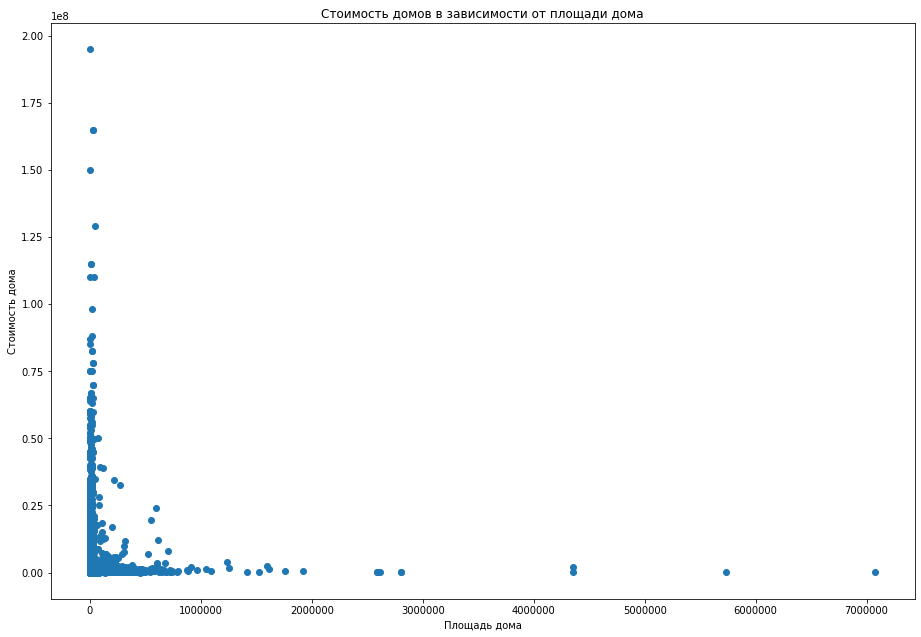

In [56]:
#стоимость домов в зависимости от площади
X_sqft = data[['sqft', 'target']]

fig_target_sqft = plt.figure()
axes_target_sqft = fig_target_sqft.add_axes([0, 0, 2, 2])
axes_target_sqft.set_xlabel('Площадь дома')
axes_target_sqft.set_ylabel('Стоимость дома')
axes_target_sqft.set_title('Стоимость домов в зависимости от площади дома')
plt.plot(X_sqft['sqft'], X_sqft['target'],'o')
plt.show()

## 9. поле zipcode

In [57]:
#убираем все символы, кроме цифр. Приводим к формату int
regex = re.compile('\D+')
data['zipcode_int'] = data['zipcode'].apply(lambda x: int(regex.sub('', str(x))) if regex.sub('', str(x))!='' else 0)

## 10. private pool  и PrivatePool

In [58]:
data['private pool1'] = data['private pool'].apply(lambda x: 1 if str(x).lower()=='yes' else 0)
data['PrivatePool1'] = data['PrivatePool'].apply(lambda x: 1 if str(x).lower()=='yes' else 0)
data['pool'] = data[['PrivatePool1','private pool1']].values.max(1)

In [59]:
data['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [60]:
data['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [61]:
data[data['pool'] > 0][['PrivatePool','private pool', 'pool']]

,PrivatePool,private pool,pool
2,yes,NaN,1
12,yes,NaN,1
19,yes,NaN,1
43,yes,NaN,1
60,Yes,NaN,1
...,...,...,...
377168,yes,NaN,1
377170,Yes,NaN,1
377171,yes,NaN,1
377174,yes,NaN,1


In [62]:
#удаляем ненужные столбцы
data = data.drop(['PrivatePool','private pool','PrivatePool1','private pool1'], axis='columns')

## 11. поле fireplace

In [63]:
print(len(data['fireplace'].unique()))
data['fireplace'].unique()[:30]

1654


array(['Gas Logs', nan, 'yes', 'Yes', '2', '0', '1', 'Not Applicable',
       'Fireplace YN', '5', 'Family Room, Master Bedroom', '1 Fireplace',
       'Fireplace', 'Living Room, Wood Burning',
       '1 Fireplace, Exterior Fireplace', '3', 'N/K',
       'Firepit, Gas Fireplace', 'Gas Logs, In Den/Family Room',
       'FAMILYRM', 'Wood', 'Direct Vent, Gas Log, 1 Fireplace',
       'Family Room, Living Room, Wood Burning',
       '1 Fireplace, Wood Burning', 'Extra Closets',
       'Gas Logs, Great Room', 'Special Features', 'No', 'Gas, Propane',
       'Great Room'], dtype=object)

In [64]:
#пока простая обработка "есть/нет"
data['fireplace_y_n'] = data['fireplace'].apply(lambda x: 0 if (str(x) == 'nan' 
                                                                or str(x).lower() == 'not applicable' 
                                                                or str(x).lower() == 'no') else 1)



In [65]:
#Работа с обогревом. Смотрим частоту встречания разных вариантов
fireplace_list = []
for x in data['fireplace']:
    if type(x) is str:
        #print(ast.literal_eval(x))
        li = x.split(',') #преобразуем строку "со списком" в настоящий список
        #print(li)
        for i in li:
            fireplace_list.append(i.strip())

#считаем сколько раз упоминается 
fireplace_dict = {} #делаем словарь с количеством упоминаний
for i in fireplace_list:
    if i not in fireplace_dict.keys():
        fireplace_dict[i] = 0
    fireplace_dict[i] += 1

In [66]:
fireplace_dict

{'Gas Logs': 1272,
 'yes': 50017,
 'Yes': 20619,
 '2': 2418,
 '0': 262,
 '1': 14479,
 'Not Applicable': 1990,
 'Fireplace YN': 287,
 '5': 65,
 'Family Room': 539,
 'Master Bedroom': 129,
 '1 Fireplace': 758,
 'Fireplace': 910,
 'Living Room': 1153,
 'Wood Burning': 1108,
 'Exterior Fireplace': 46,
 '3': 562,
 'N/K': 47,
 'Firepit': 75,
 'Gas Fireplace': 228,
 'In Den/Family Room': 213,
 'FAMILYRM': 654,
 'Wood': 235,
 'Direct Vent': 35,
 'Gas Log': 260,
 'Extra Closets': 683,
 'Great Room': 626,
 'Special Features': 279,
 'No': 289,
 'Gas': 491,
 'Propane': 26,
 'Ceiling Fan': 1318,
 'Storage': 650,
 'Utility Connection': 672,
 'Insert': 24,
 'Fireplace Features': 239,
 'In Great Room': 209,
 'Central Vacuum': 82,
 'Elevator': 70,
 'Walk-In Closets': 1042,
 'Natural Gas': 164,
 'Baseboard': 3,
 'Fireplace-Wood': 48,
 'Hot Water/Steam': 12,
 'Radiators': 9,
 'Gas Log Starter': 79,
 'Electric': 169,
 'Wood Burning FP': 137,
 'Fireplace Living Rm': 109,
 'Wood Burning Frplc': 37,
 'Other 

In [67]:
#посчитаем, сколько характеристик указано для дома
data['fp_count']=data['fireplace'].apply(lambda x: len(str(x).split(',')))

In [68]:
data[data['fp_count']>3][['fireplace_y_n','fireplace', 'fp_count']]

,fireplace_y_n,fireplace,fp_count
841,1,"Ceiling Fan, Extra Closets, Storage, Utility C...",4
1116,1,"Ceiling Fan, Central Vacuum, Elevator, Extra C...",6
1343,1,"Baseboard, Fireplace-Wood, Hot Water/Steam, Ra...",4
1661,1,"Ceiling Fan, Extra Closets, Storage, Utility C...",5
2124,1,"Ceiling Fan, Redecorated, Storage, Utility Con...",5
...,...,...,...
375492,1,"Ceiling Fan, Fire Sprinkler System, Storage, U...",4
375630,1,"Fireplace-Gas, Fireplace-Wood, Patio, Walk-in ...",4
376034,1,"Ceiling Fan, SMAPL, Utility Connection, Walk-I...",4
376122,1,"Gas Logs, In Bedroom, In Den/Family Room, In L...",4


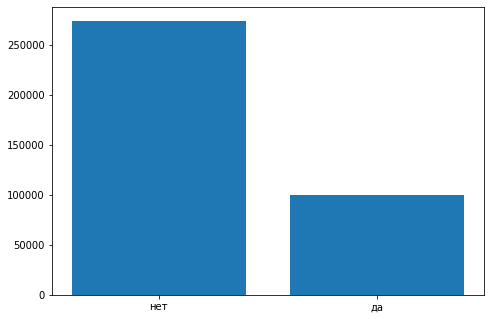

In [69]:
#считаем распределение 
fireplace = data.groupby('fireplace_y_n')['fireplace_y_n'].count().sort_values(ascending=False)

fig_fireplace = plt.figure()
axes_fireplace = fig_fireplace.add_axes([0,0,1,1])
axes_fireplace.bar(x = ['нет', 'да'], height = fireplace.values)
axes_fireplace.set_xticklabels(['нет', 'да'], rotation = 0 )    #  Поворот текста
plt.show()

In [70]:
data=data.drop(['fireplace'], axis = 'columns')

## 12. поле stories

In [71]:
data['stories'].unique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '1.5 Stories', '7',
       '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
       '1 

In [72]:
# заменяем нан на 1 этаж
data['stories'].fillna(1, inplace=True)

def make_stories(row):
    regex_sq = re.compile('\D+')
    try:
        row=float(row)
    except:
        row=regex_sq.sub('', str(row))
        if row != '':
            row = float(row)
        else:
            row = 1
    return row

#убираем все символы, кроме цифр. Приводим к формату int
regex_sq = re.compile('\D+')
data['stories_count']=data['stories'].apply(lambda x: make_stories(x))

In [73]:
data['stories_count'].value_counts()

1.0       254639
2.0        78778
3.0        17110
0.0        11440
9.0         3381
           ...  
82.0           1
1234.0         1
65.0           1
1002.0         1
1120.0         1
Name: stories_count, Length: 90, dtype: int64

In [74]:
data=data.drop(['stories'], axis = 'columns')

## 13. поле state

In [75]:
data['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

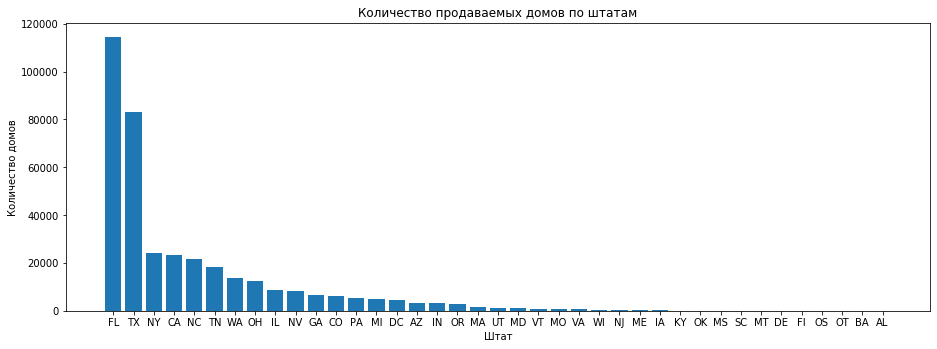

In [76]:
#считаем распределение по штатам
states = data.groupby('state')['state'].count().sort_values(ascending=False)

fig_states = plt.figure()
axes_states = fig_states.add_axes([0,0,2,1])
axes_states.bar(x = states.index, height = states.values)
axes_states.set_xlabel('Штат')
axes_states.set_ylabel('Количество домов')
axes_states.set_title('Количество продаваемых домов по штатам')

axes_states.set_xticklabels(states.index, rotation =0 )    #  Поворот текста
plt.show()

In [77]:
#заменим на числа
#в конце сохраним этот список, чтобы обрабатывать строку на входе
data['state_encoding'], states_list = data['state'].factorize()

In [78]:
states_list

Index(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC', 'NV',
       'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT', 'MD', 'CO',
       'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT', 'DE', 'Fl', 'BA',
       'AL', 'OT', 'OS'],
      dtype='object')

In [79]:
#убираем обработанный столбец
data = data.drop(['state'], axis = 'columns')

## 14. поле HomeFacts

In [80]:
data['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [81]:
#смотрим, какие вообще факты могут быть. Если их небольшое количество, то разложим в разные столбцы
for i in data['homeFacts']:
    fact_list = []
    hf = eval(i)['atAGlanceFacts']
    for k in hf:
        fact_list.append(k['factLabel'])
set(fact_list)

{'Cooling',
 'Heating',
 'Parking',
 'Price/sqft',
 'Remodeled year',
 'Year built',
 'lotsize'}

In [82]:
def make_facts(row, columns):
    fact_dict = {}
    for i in columns:
        fact_dict[i]=float('nan')
    row = eval(row)['atAGlanceFacts']
    for i in row:
        fact_dict[i['factLabel']]=i['factValue']
    return pd.Series(fact_dict)
    

In [83]:
fact_columns = ['Cooling',  'Heating', 'Parking', 'Price/sqft', 'Remodeled year', 'Year built', 'lotsize']
data[fact_columns]=data['homeFacts'].apply(lambda x: make_facts(x,fact_columns))

In [84]:
data[fact_columns]

,Cooling,Heating,Parking,Price/sqft,Remodeled year,Year built,lotsize
0,,"Central A/C, Heat Pump",,$144,,2019,None
1,,,,$159/sqft,,2019,5828 sqft
2,Central,Forced Air,Attached Garage,$965/sqft,1967,1961,"8,626 sqft"
3,Central,Forced Air,Detached Garage,$371/sqft,2006,2006,"8,220 sqft"
4,,,,None,,,"10,019 sqft"
...,...,...,...,...,...,...,...
377180,Central,Other,2 spaces,$311,1990,1990,"8,500 sqft"
377181,,Radiant,None,$337/sqft,,1924,
377182,,Other,2,$458/sqft,1950,1950,"1,600 sqft"
377183,None,None,None,None,None,None,None


In [85]:
#Cooling, Heating, Parking меняем на 1 (есть), 0(нет)
for i in ['Cooling', 'Heating', 'Parking']:
    data[i].fillna(0, inplace = True)
    data[i] = data[i].apply(lambda x: 0 if x == np.nan or x in ['', 'No','None', 'no', 0, 'No Data'] else 1)

In [86]:
#в цене за кв. фут избавляемся от всяких лишних знаков, переводим в целое число
def make_price(row):
    row = str(row).replace('$','').replace('/sqft','').replace(' / Sq. Ft.', '').replace(',','')
    try:
        row = int(row)
    except:
        if row in ['None', 'No Info', 'No Data', '', 'Contact manager']:
            row = 0
        else:
            row = 0
    return row

In [87]:
data['price']=data['Price/sqft'].apply(lambda x: make_price(x))

In [88]:
#преобразуем год в число
for i in ['Remodeled year', 'Year built']:
    data[i.split()[0]] = data[i].apply(lambda x: int(x) if str(x) not in ['', 'None','No Data'] else 0)


In [89]:
#удалим строки с выбросом по году постройки
data = data.loc[data['Year']!=559990649990]

In [90]:
#в размере лота убираем лишние знаки, переводим все в единые единицы измерения
def make_lot(row):
    row1 = row
    row = str(row).replace('$','').replace(' sqft lot','').replace(' Sq. Ft.', '').replace(' sqft', '').replace(',','')
    try:
        row = float(row)
    except:
        if row.lower().find('acre') >-1:
            row = row.lower().replace(' lot', '').replace(' acres', '').replace(' acre', '').replace(' acres', '')
        try:
            row = float(row) * 43560.04
        except:
            if row in ['None', 'No Info', 'No Data', '', 'Contact manager', '--', '—']:
                row = 0
            else:
                print(row, '->', row1)
    return row

In [91]:
data['lot'] = data['lotsize'].apply(lambda x: make_lot(x))

In [92]:
#удаляем обработанные столбцы
data = data.drop(['lotsize', 'Remodeled year', 'Year built', 'Price/sqft', 'homeFacts'], axis = 'columns')

## 15. mls-id

In [93]:
#делаем списки идентификаторов и ищем пересечение
s1 = set(data['mls-id'].unique())
s2 = set(data['MlsId'].unique())
s3 = s2.intersection(s1)
print('Пересекаются {0} значений'.format(len(s3)))
print('mls-id = {0} значений, MlsId = {1} значений'.format(len(s1), len(s2)))

Пересекаются 8832 значений
mls-id = 24903 значений, MlsId = 232828 значений


In [94]:
#соединяем идентификаторы в одну колонку, так удобнее с ними работать
data['mls-id'].fillna('', inplace=True)
data['MlsId'].fillna('', inplace=True)
data['new_id']=data['mls-id'].astype(str)+data['MlsId'].astype(str)

#проверяем, может есть строки, в которых идентификатор совсем не проставлен. Эти строки не трогаем, оставляем как есть
print('В {0} строках не проставлен идентификатор'.format(data[data['new_id']=='']['new_id'].count()))

data=data.drop(['mls-id', 'MlsId'], axis = 'columns')

В 39540 строках не проставлен идентификатор


In [95]:
#избавляемся от оставшихся лишних столбцов
data=data.drop(['status', 'zipcode'], axis = 'columns')

In [96]:
#остались только обработанные столбцы. Попробуем поискать полные дубликаты
data1 = data.drop_duplicates()
print(len(data), '->', len(data1))

374462 -> 374379


In [97]:
#полные дубликаты удалены. Посчитаем hash для идентификатора. Так как он содержит и буквы тоже
data= data1
hash_space = 500000
data['new_id'] = data['new_id'].apply(lambda x: hash(''.join(x.lower().split())) % hash_space)

## Как правило стоимость дома можно оценить исходя из стоимость квадратного фута. У нас есть price и sqft, и lotsize. Поэтому добавляем в датасет еще два поля

In [98]:
data['price_sqft'] = data['price']*data['sqft']
data['price_lot']=data['price']*data['lot']

## Удаляем все оставшиеся ненужные столбцы и сохраняем датасет для дальнейшей работы

In [99]:
#удаляем дубликаты строк, которые имеют разную стоимость
#удаляем все спорные строки, так как неизвестно, какая из них правильная
columns = list(set(data.columns) - set(['target']))
data.drop_duplicates(subset = columns, keep = False, inplace= True) 

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374365 entries, 0 to 377184
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sqft                 374365 non-null  int64  
 1   target               374365 non-null  int64  
 2   state_mean           374365 non-null  float64
 3   rent_sale            374365 non-null  int64  
 4   prop_type            374365 non-null  int64  
 5   city_hash            374365 non-null  int64  
 6   street_hash          374365 non-null  int64  
 7   address_hash         374365 non-null  int64  
 8   baths_count          374365 non-null  float64
 9   beds_count           374365 non-null  int64  
 10  beds_square          374365 non-null  float64
 11  K                    374365 non-null  float64
 12  1                    374365 non-null  float64
 13  2                    374365 non-null  float64
 14  3                    374365 non-null  float64
 15  4                

In [101]:
#сохраняем обработанный датасет
data.to_csv('data4ml.csv', encoding='utf-8', index=False)


In [102]:
#сохраняем список штатов, он нам потом понадобится
with open('states_list.txt', 'wb') as f:
    pickle.dump(states_list, f)

In [103]:
#сохраняем среднюю стоимость по штататм, она нам потом понадобится
with open('mean_target.txt', 'wb') as f:
    pickle.dump(mean_target, f)